# Packages

In [397]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings
import time
import holidays
import pickle

# Modelling
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
    mean_squared_error
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold

from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss

from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.utils import AirPassengers as ap

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [398]:
df = pl.read_csv(
    "../0_data/preprocessed/df_final_reduced.csv", try_parse_dates=True
).filter(pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00"))

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm
datetime[μs],f64,f64,f64
2021-09-01 00:00:00,5.1633e6,0.0,16.042
2021-09-01 01:00:00,5.0777e6,0.0,15.892
2021-09-01 02:00:00,4.9315e6,0.0,16.042
2021-09-01 03:00:00,4.7878e6,0.0,15.942
2021-09-01 04:00:00,4.7038e6,0.0,15.792001


In [399]:
df.shape

(26304, 4)

In [400]:
df

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm
datetime[μs],f64,f64,f64
2021-09-01 00:00:00,5.1633e6,0.0,16.042
2021-09-01 01:00:00,5.0777e6,0.0,15.892
2021-09-01 02:00:00,4.9315e6,0.0,16.042
2021-09-01 03:00:00,4.7878e6,0.0,15.942
2021-09-01 04:00:00,4.7038e6,0.0,15.792001
…,…,…,…
2024-08-31 19:00:00,5.3614e6,179.0,22.942
2024-08-31 20:00:00,5.3775e6,41.0,23.042
2024-08-31 21:00:00,5.2130e6,0.0,23.092


# Missing values

Just forward fill for now.

In [401]:
df = df.fill_null(strategy="forward")

# Lags

Include target variable lags.

- Same hour on previous day
- Average consumption during the past week

## Exogenous Variables

Rolling features:

- 7d average:
    - Temperature

In [402]:
rolling_features_7d = (
    df.select("datetime", "Zurich_soil_temperature_7_to_28cm")
    .with_columns(
        temp_rolling=pl.col("Zurich_soil_temperature_7_to_28cm").rolling_mean(24 * 7),
        datetime=pl.col("datetime").dt.offset_by("1d"),
    )
    .drop("Zurich_soil_temperature_7_to_28cm")
)

In [403]:
df = df.join(rolling_features_7d, how="left", on="datetime", coalesce=True)

In [404]:
(df["datetime"] - df["datetime"].shift(1)).value_counts()

datetime,count
duration[μs],u32
null,1
1h,26303


# Calendar Features

In [405]:
df = df.with_columns(
    day_of_month=pl.col("datetime").dt.day(),
    day_of_year=pl.col("datetime").dt.ordinal_day(),
    day_of_week=pl.col("datetime").dt.weekday(),
    month=pl.col("datetime").dt.month(),
    hour=pl.col("datetime").dt.hour(),
)

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,temp_rolling,day_of_month,day_of_year,day_of_week,month,hour
datetime[μs],f64,f64,f64,f64,i8,i16,i8,i8,i8
2021-09-01 00:00:00,5.1633e6,0.0,16.042,null,1,244,3,9,0
2021-09-01 01:00:00,5.0777e6,0.0,15.892,null,1,244,3,9,1
2021-09-01 02:00:00,4.9315e6,0.0,16.042,null,1,244,3,9,2
2021-09-01 03:00:00,4.7878e6,0.0,15.942,null,1,244,3,9,3
2021-09-01 04:00:00,4.7038e6,0.0,15.792001,null,1,244,3,9,4


# Holidays

In [406]:
# Define the region (Canton of Berne) and the country (Switzerland)
country = "CH"
prov = "ZH"

# Create a list of the regional holidays for the canton of Berne
regional_holidays = holidays.CH(
    years=df["datetime"].dt.year().unique().to_list(), prov=prov
)

holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
).sort("holiday_date")

holiday_df["holiday_name"].value_counts()

holiday_name,count
str,u32
"""Auffahrt""",4
"""Neujahrestag""",4
"""Tag der Arbeit""",4
"""Weihnachten""",4
"""Stephanstag""",4
"""Berchtoldstag""",4
"""Ostermontag""",4
"""Karfreitag""",4
"""Pfingstmontag""",4


In [407]:
# Define holiday names
holiday_names = [
    # Osterferienzeit (Easter Holiday Season)
    "Osterferienzeit_1",
    "Osterferienzeit_2",
    "Osterferienzeit_3",
    "Osterferienzeit_4",
    "Osterferienzeit_5",
    # Auffahrtferienzeit (Ascension Holiday Season)
    "Auffahrtferienzeit_1",
    "Auffahrtferienzeit_2",
    "Auffahrtferienzeit_3",
    "Auffahrtferienzeit_4",
    "Auffahrtferienzeit_5",
]

# Repeat holiday names for each year
holiday_names_full = holiday_names * 4

# Define holiday dates
holiday_dates = [
    # 2021
    "2021-03-31",
    "2021-04-01",
    "2021-04-02",
    "2021-04-03",
    "2021-04-04",
    "2021-05-12",
    "2021-05-13",
    "2021-05-14",
    "2021-05-15",
    "2021-05-16",
    # 2022
    "2022-04-13",
    "2022-04-14",
    "2022-04-15",
    "2022-04-16",
    "2022-04-17",
    "2022-05-25",
    "2022-05-26",
    "2022-05-27",
    "2022-05-28",
    "2022-05-29",
    # 2023
    "2023-04-05",
    "2023-04-06",
    "2023-04-07",
    "2023-04-08",
    "2023-04-09",
    "2023-05-17",
    "2023-05-18",
    "2023-05-19",
    "2023-05-20",
    "2023-05-21",
    # 2024
    "2024-03-27",
    "2024-03-28",
    "2024-03-29",
    "2024-03-30",
    "2024-03-31",
    "2024-05-08",
    "2024-05-09",
    "2024-05-10",
    "2024-05-11",
    "2024-05-12",
]

# Create the DataFrame
holiday_manual_df = pl.DataFrame(
    {
        "holiday_name": holiday_names_full,
        "holiday_date": holiday_dates,
    }
).with_columns(
    pl.col("holiday_date").str.to_date()
)  # Define holiday names
holiday_names = [
    # Osterferienzeit (Easter Holiday Season)
    "Osterferienzeit_1",
    "Osterferienzeit_2",
    "Osterferienzeit_3",
    "Osterferienzeit_4",
    "Osterferienzeit_5",
    # Auffahrtferienzeit (Ascension Holiday Season)
    "Auffahrtferienzeit_1",
    "Auffahrtferienzeit_2",
    "Auffahrtferienzeit_3",
    "Auffahrtferienzeit_4",
    "Auffahrtferienzeit_5",
]

# Repeat holiday names for each year
holiday_names_full = holiday_names * 4

# Define holiday dates
holiday_dates = [
    # 2021
    "2021-03-31",
    "2021-04-01",
    "2021-04-02",
    "2021-04-03",
    "2021-04-04",
    "2021-05-12",
    "2021-05-13",
    "2021-05-14",
    "2021-05-15",
    "2021-05-16",
    # 2022
    "2022-04-13",
    "2022-04-14",
    "2022-04-15",
    "2022-04-16",
    "2022-04-17",
    "2022-05-25",
    "2022-05-26",
    "2022-05-27",
    "2022-05-28",
    "2022-05-29",
    # 2023
    "2023-04-05",
    "2023-04-06",
    "2023-04-07",
    "2023-04-08",
    "2023-04-09",
    "2023-05-17",
    "2023-05-18",
    "2023-05-19",
    "2023-05-20",
    "2023-05-21",
    # 2024
    "2024-03-27",
    "2024-03-28",
    "2024-03-29",
    "2024-03-30",
    "2024-03-31",
    "2024-05-08",
    "2024-05-09",
    "2024-05-10",
    "2024-05-11",
    "2024-05-12",
]

# Create the DataFrame
holiday_manual_df = pl.DataFrame(
    {
        "holiday_name": holiday_names_full,
        "holiday_date": holiday_dates,
    }
).with_columns(pl.col("holiday_date").str.to_date())

In [408]:
holiday_df = (
    pl.concat(
        [
            holiday_df,
            holiday_manual_df,
        ],
        how="vertical",
    )
    .sort("holiday_date")
    .unique("holiday_date")
)

In [409]:
df = (
    df.with_columns(date=pl.col("datetime").dt.date())
    .join(holiday_df, how="left", left_on="date", right_on="holiday_date")
    .drop("date")
    .with_columns(holiday_name=pl.col("holiday_name").fill_null("no_holiday"))
)

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,temp_rolling,day_of_month,day_of_year,day_of_week,month,hour,holiday_name
datetime[μs],f64,f64,f64,f64,i8,i16,i8,i8,i8,str
2021-09-01 00:00:00,5.1633e6,0.0,16.042,null,1,244,3,9,0,"""no_holiday"""
2021-09-01 01:00:00,5.0777e6,0.0,15.892,null,1,244,3,9,1,"""no_holiday"""
2021-09-01 02:00:00,4.9315e6,0.0,16.042,null,1,244,3,9,2,"""no_holiday"""
2021-09-01 03:00:00,4.7878e6,0.0,15.942,null,1,244,3,9,3,"""no_holiday"""
2021-09-01 04:00:00,4.7038e6,0.0,15.792001,null,1,244,3,9,4,"""no_holiday"""


# Cyclical Encoding

In [410]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclically(column_name, periodicity, table):
    # Create sin and cos encoding
    table = table.with_columns(
        sin_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_sin")
    )

    table = table.with_columns(
        cos_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_cos")
    )
    # Drop the old column
    table = table.drop(column_name)

    return table

In [411]:
# Dictionary with column name and calendar periodicity
calendar_features = {
    "day_of_month": 31,
    "day_of_year": 365,
    "day_of_week": 7,
    "month": 12,
    "hour": 24,
}

for column_name, periodicity in calendar_features.items():
    df = encode_cyclically(column_name, periodicity, df)

# sklearn Pipeline

In [412]:
cat_cols = ["holiday_name"]

num_cols = df.select(
    cs.contains(
        "soil_temperature_7_to_28cm",
        "shortwave_radiation",
    )
).columns + ["temp_rolling"]

manual_cols = df.select(pl.selectors.contains("_cos", "_sin", "is_")).columns

In [413]:
df.drop(manual_cols + cat_cols + num_cols).columns

['datetime', 'kWh']

In [414]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

In [415]:
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

In [416]:
column_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

In [417]:
preprocessor = Pipeline(
    steps=[
        ("column_transformer", column_transformer),
        (
            "variance_threshold",
            VarianceThreshold(threshold=0.0),
        ),  # Drops constant columns after transformations
    ]
)

# Autocorrelation Visualisation

## No differencing

In [418]:
time_series = df.to_pandas()["kWh"]
acf_lags = 24 * 8

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.972902,0.960817,0.984987,1
2,0.907338,0.886783,0.927893,2
3,0.823625,0.797877,0.849373,3
4,0.736739,0.707394,0.766083,4


In [419]:
significance_thr = 1.96 / np.sqrt(len(time_series))

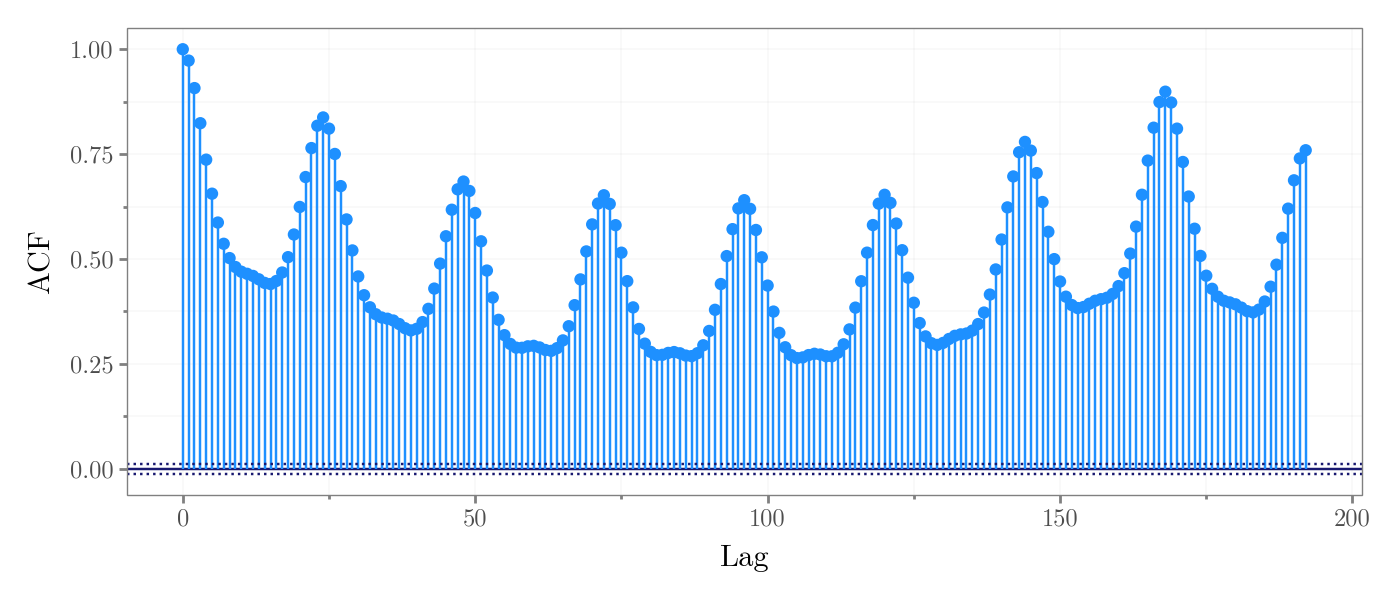

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning:

Saving 7 x 3 in image.

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning:

Filename: ../1_figures/acf_differencing_0.pdf



In [420]:
plot_width = 7
plot_height = 3

fig = (
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/acf_differencing_0.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

In [421]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.972939,0.960854,0.985024,1
2,-0.734299,-0.746384,-0.722215,2
3,0.285290,0.273205,0.297374,3
4,-0.003155,-0.015240,0.008930,4


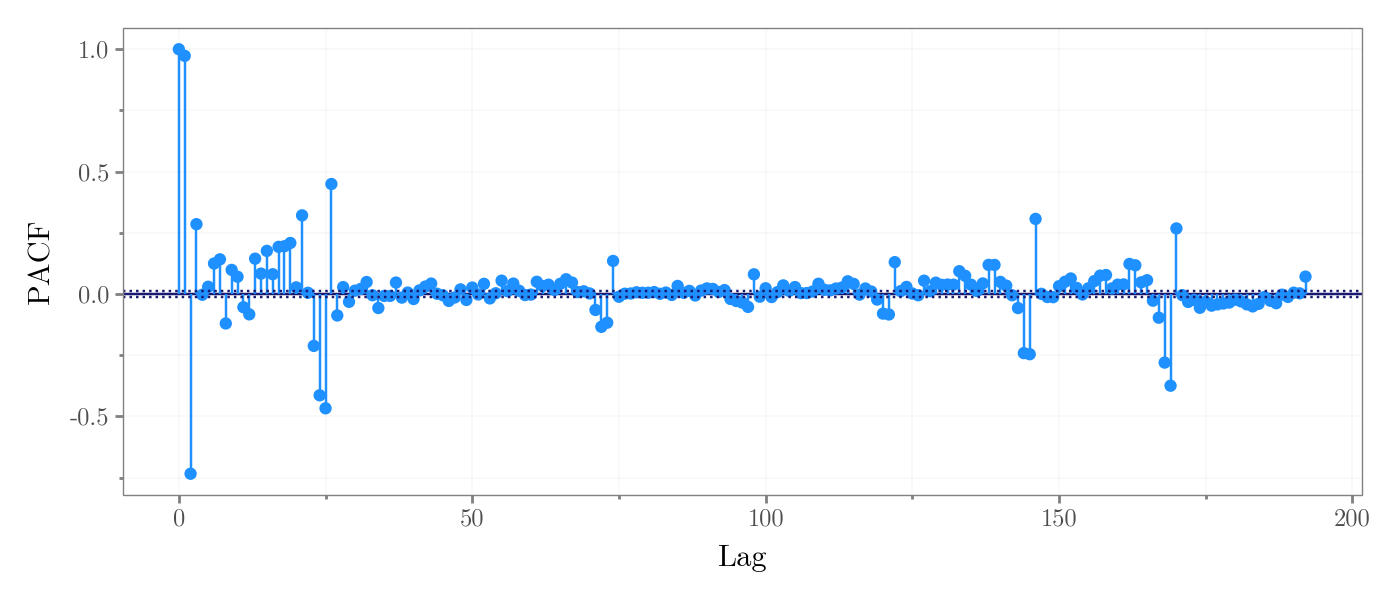

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning:

Saving 7 x 3 in image.

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning:

Filename: ../1_figures/pacf_differencing_0.pdf



In [422]:
plot_width = 7
plot_height = 3

fig = (
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/pacf_differencing_0.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

In [423]:
# Perform the ADF test
adf_result = adfuller(time_series)

# Display the results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.3f}")

# Interpretation
if adf_result[1] < 0.05:
    print("The time series is likely stationary (reject the null hypothesis).")
else:
    print(
        "The time series is likely non-stationary (fail to reject the null hypothesis)."
    )

ADF Statistic: -10.187471076568048
p-value: 6.451808110433315e-18
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567
The time series is likely stationary (reject the null hypothesis).


In [424]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [425]:
kpss_test(time_series)

Results of KPSS Test:
Test Statistic            3.932698
p-value                   0.010000
Lags Used                86.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\mathi\AppData\Local\Temp\ipykernel_20192\11026176.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




## First order differencing

In [436]:
time_series = df.to_pandas()["kWh"]
time_series = (time_series - time_series.shift(168)).dropna()
time_series = (time_series - time_series.shift(1)).dropna()

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.548680,0.536556,0.560804,1
2,0.241448,0.226103,0.256794,2
3,0.063414,0.047520,0.079308,3
4,-0.057971,-0.073902,-0.042040,4


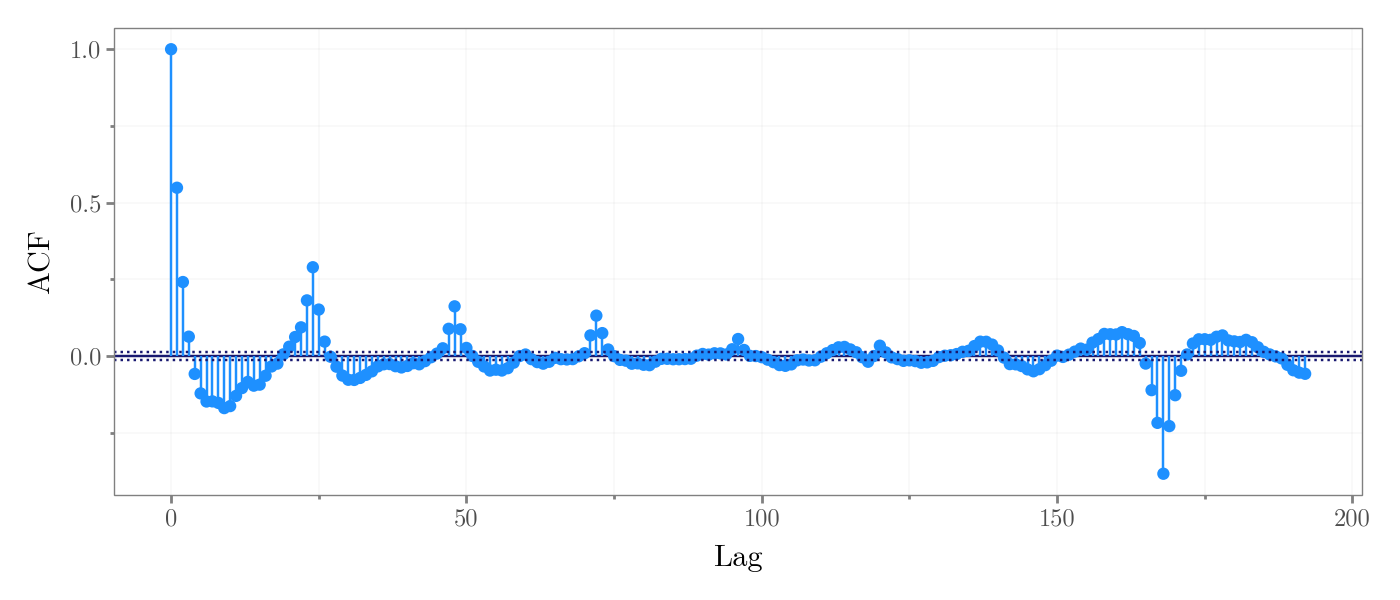

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning:

Saving 7 x 3 in image.

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning:

Filename: ../1_figures/acf_differencing_1.pdf



In [437]:
plot_width = 7
plot_height = 3

fig = (
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/acf_differencing_1.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

In [438]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.548701,0.536577,0.560825,1
2,-0.085282,-0.097406,-0.073158,2
3,-0.048392,-0.060515,-0.036268,3
4,-0.079886,-0.092009,-0.067762,4


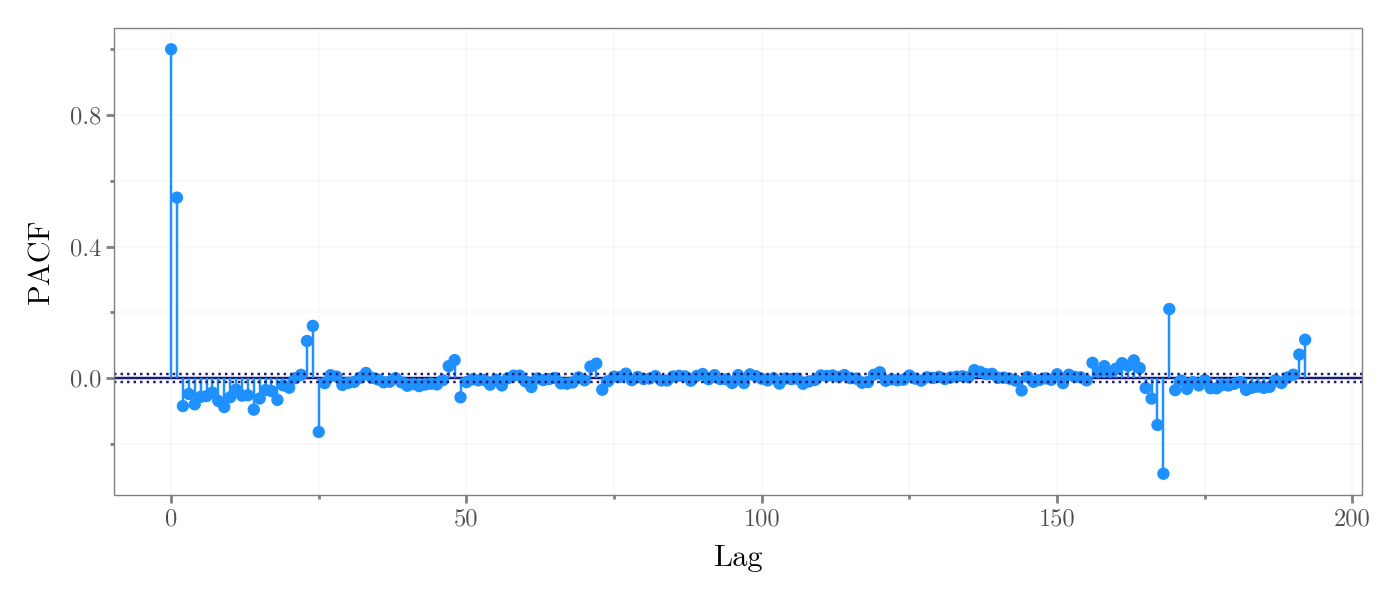

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning:

Saving 7 x 3 in image.

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning:

Filename: ../1_figures/pacf_differencing_1.pdf



In [439]:
plot_width = 7
plot_height = 3

fig = (
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/pacf_differencing_1.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

In [440]:
# Perform the ADF test
adf_result = adfuller(time_series)

# Display the results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.3f}")

# Interpretation
if adf_result[1] < 0.05:
    print("The time series is likely stationary (reject the null hypothesis).")
else:
    print(
        "The time series is likely non-stationary (fail to reject the null hypothesis)."
    )

ADF Statistic: -28.57310529914637
p-value: 0.0
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567
The time series is likely stationary (reject the null hypothesis).


In [431]:
kpss_test(time_series)

Results of KPSS Test:
Test Statistic             0.002849
p-value                    0.100000
Lags Used                132.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


C:\Users\mathi\AppData\Local\Temp\ipykernel_20192\11026176.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




# Order Selection (Parameter Tuning) with `statsforecast`

## Computational complexity extrapolation chart

In [22]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,temp_rolling,holiday_name,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,,
2021-09-01 00:00:00,5.163270e+06,0.0,16.042000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.000000,1.000000
2021-09-01 01:00:00,5.077656e+06,0.0,15.892000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.258819,0.965926
2021-09-01 02:00:00,4.931528e+06,0.0,16.042000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.500000,0.866025
2021-09-01 03:00:00,4.787832e+06,0.0,15.942000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.707107,0.707107
2021-09-01 04:00:00,4.703846e+06,0.0,15.792001,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.866025,0.500000


In [23]:
# Go a lot smaller on the data to make computation feasible
df_train = df_full["2023-06-01":"2023-06-30"]
df_val = df_full["2023-07-01":"2023-07-31"]

In [24]:
X_train = df_train.drop(columns=["kWh"])
X_val = df_val.drop(columns=["kWh"])

In [25]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [26]:
X_train_preprocessed = X_train_preprocessed.apply(pd.to_numeric, errors="coerce")
X_val_preprocessed = X_val_preprocessed.apply(pd.to_numeric, errors="coerce")

In [ ]:
n_obs_list = np.arange(200, 700 + 1, 100)
fit_times = []

for n_obs in tqdm(n_obs_list):

    model = ARIMA(
        order=(1, 1, 1),
        season_length=24,
        seasonal_order=(1, 1, 1),
        # include_drift=True
    )

    start_time = time.time()
    model.fit(
        y=y_train.head(n_obs).to_numpy(dtype=np.float64),
        X=X_train_preprocessed.head(n_obs).to_numpy(dtype=np.float64),
    )
    end_time = time.time()
    fit_times.append((end_time - start_time) / 60)

In [ ]:
(
    pn.ggplot(
        data=pd.DataFrame({"n": n_obs_list, "fit_time": fit_times}),
        mapping=pn.aes("n", "fit_time"),
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.labs(
        title="SARIMAX fit times depending on number of observations",
        subtitle="SARIMAX(1,1,1)(1,1,1)(24)",
        x="# observations",
        y="Fit Time (minutes)",
    )
    + pn.geom_smooth(method="lm", colour="blue", size=0.25)
    + theme_academic
)

Extrapolation linearly: SARIMAX on hourly data with this configuration will take (minutes):

In [ ]:
df.shape[0] / n_obs_list[-1] * fit_times[-1]

## Manually Fitting a Model

In [52]:
def validation(model, X_train, X_val, y_train, y_val, verbose=True):
    # Validation loop (predict the next 24 hours for the validation period)
    X_train_val = pd.concat([X_train, X_val], axis=0)
    y_train_val = pd.concat([y_train, y_val], axis=0)

    # To prevent function becoming slow due to linearly growing history
    max_history_obs = 168 * 2

    val_index = X_train.shape[0]
    horizon = 24
    val_preds = np.array([])

    while val_index + horizon <= X_train_val.shape[0]:

        y_pred = model.forward(
            y=y_train_val[
                np.amax([0, val_index - max_history_obs]) : val_index
            ].to_numpy(dtype=np.float64),
            h=24,
            X=X_train_val[
                np.amax([0, val_index - max_history_obs]) : val_index
            ].to_numpy(dtype=np.float64),
            X_future=X_train_val[val_index : val_index + horizon].to_numpy(
                dtype=np.float64
            ),
        )["mean"]

        # Append to array
        val_preds = np.append(val_preds, y_pred)

        # Increment validation index
        val_index += horizon

        if (val_position := val_index - X_train.shape[0]) % 24 == 0 and verbose:
            print(f"Hour {val_position} of {X_val.shape[0]}")
            clear_output(wait=True)

    return np.vstack(val_preds).flatten()

In [53]:
df_full = (
    df.to_pandas()
    .assign(
        datetime=lambda x: x.datetime.astype("datetime64[ns]"),
    )
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,temp_rolling,holiday_name,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,,
2021-09-01 00:00:00,5.163270e+06,0.0,16.042000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.000000,1.000000
2021-09-01 01:00:00,5.077656e+06,0.0,15.892000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.258819,0.965926
2021-09-01 02:00:00,4.931528e+06,0.0,16.042000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.500000,0.866025
2021-09-01 03:00:00,4.787832e+06,0.0,15.942000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.707107,0.707107
2021-09-01 04:00:00,4.703846e+06,0.0,15.792001,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.866025,0.500000


In [54]:
# Go a lot smaller on the data to make computation feasible
df_train = df_full["2023-06-01":"2023-06-30"]
df_val = df_full["2023-07-01":"2023-07-31"]

In [55]:
X_train = df_train.drop(columns=["kWh"])
X_val = df_val.drop(columns=["kWh"])

In [56]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [ ]:
model = ARIMA(
    order=(1, 1, 1),
    season_length=168,
    seasonal_order=(1, 1, 1),
    # include_drift=True
)

model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [ ]:
# this is the setup to predict one day into the future
# without refitting the model

y_preds = model.forward(
    y=y_train.to_numpy(dtype=np.float64),
    h=24,
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
    X_future=X_val_preprocessed.head(24).to_numpy(dtype=np.float64),
)["mean"]

y_preds

In [ ]:
y_pred = validation(
    model=model,
    X_train=X_train_preprocessed,
    X_val=X_val_preprocessed,
    y_train=y_train,
    y_val=y_val,
)


preds_168 = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_val,
    }
)

In [ ]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    preds_168.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [ ]:
model = ARIMA(
    order=(1, 1, 1),
    season_length=24,
    seasonal_order=(1, 1, 1),
    # include_drift=True
)

model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [ ]:
y_pred = validation(
    model=model,
    X_train=X_train_preprocessed,
    X_val=X_val_preprocessed,
    y_train=y_train,
    y_val=y_val,
)


preds_24 = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_val,
    }
)

In [ ]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    preds_24.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [ ]:
pd.concat(
    [
        preds_168.assign(seasonality=168).reset_index(),
        preds_24.assign(seasonality=24).reset_index(),
    ],
    axis=0,
).to_csv("3_SARIMAX_seasonality_24_168_comparison.csv", index=False)

In [ ]:
plot_width = 7
plot_height = 3

fig = (
    pn.ggplot(
        data=(
            pd.read_csv(
                "3_SARIMAX_seasonality_24_168_comparison.csv", parse_dates=["datetime"]
            )
            .melt(id_vars=["datetime", "seasonality"])
            .assign(
                seasonality=lambda x: pd.Categorical(
                    np.where(x["seasonality"] == 168, "s=168", "s=24"),
                    categories=["s=24", "s=168"],
                    ordered=True,
                ),
                variable=lambda x: np.where(
                    x["variable"] == "pred", "Prediction", "Actual"
                ),
            )
        ),
        mapping=pn.aes("datetime", "value", colour="variable"),
    )
    + pn.geom_step()
    + pn.labs(y="kWh")
    + pn.facet_wrap("~ seasonality", ncol=1)
    + pn.scale_colour_manual(values=jama_colour)
    + pn.scale_x_datetime(date_breaks="1 week")
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
        axis_title_x=pn.element_blank(),
        legend_title=pn.element_blank(),
    )
)

display(fig)
fig.save(
    filename="../1_figures/sarimax_seasonality_24_vs_168.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## AutoARIMA

Use information criterion to select the model.

In [27]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,temp_rolling,holiday_name,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,,
2021-09-01 00:00:00,5.163270e+06,0.0,16.042000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.000000,1.000000
2021-09-01 01:00:00,5.077656e+06,0.0,15.892000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.258819,0.965926
2021-09-01 02:00:00,4.931528e+06,0.0,16.042000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.500000,0.866025
2021-09-01 03:00:00,4.787832e+06,0.0,15.942000,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.707107,0.707107
2021-09-01 04:00:00,4.703846e+06,0.0,15.792001,NaN,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.866025,0.500000


In [28]:
df_train = df_full[:"2023-08-31"]

In [29]:
X_train = df_train.drop(columns=["kWh"])

In [30]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]

In [31]:
%%capture
model = AutoARIMA(
    d=1,
    D=1,
    max_p=24,
    max_q=24,
    max_P=1,
    max_Q=1,
    stepwise=True,
    approximation=True,
    trace=True,
    season_length=168,
)

model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [32]:
# Save the entire model object
with open("autoarima_model.pkl", "wb") as f:
    pickle.dump(model.model_, f)

## Manual Validation for Order Selection

Repeat the same as manual fit (train/val split), but do order selection via fitting all order and selecting the best one (for p,q,P,Q) separately.

In [33]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)

In [34]:
# Go a lot smaller on the data to make computation feasible
df_train = df_full["2023-06-01":"2023-06-30"]
df_val = df_full["2023-07-01":"2023-07-31"]

In [35]:
X_train = df_train.drop(columns=["kWh"])
X_val = df_val.drop(columns=["kWh"])

In [36]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [ ]:
p_search_space = np.arange(0, 24 + 1)
q_search_space = np.arange(0, 24 + 1)
P_search_space = np.arange(0, 1 + 1)
Q_search_space = np.arange(0, 1 + 1)

param_search_spaces = {
    "p": p_search_space,
    "q": q_search_space,
    "P": P_search_space,
    "Q": Q_search_space,
}

y_preds_val = []

for param, search_space in param_search_spaces.items():

    for param_value in tqdm(search_space):

        current_model_config = {"p": 0, "q": 0, "P": 0, "Q": 0}
        current_model_config[param] = int(param_value)

        model = ARIMA(
            order=(current_model_config["p"], 1, current_model_config["q"]),
            season_length=168,
            seasonal_order=(current_model_config["P"], 1, current_model_config["Q"]),
        )

        # Fit the model on the training data
        model = model.fit(
            y=y_train.to_numpy(dtype=np.float64),
            X=X_train_preprocessed.to_numpy(dtype=np.float64),
        )

        # Validate the model performance
        y_pred = validation(
            model=model,
            X_train=X_train_preprocessed,
            X_val=X_val_preprocessed,
            y_train=y_train,
            y_val=y_val,
            verbose=False,
        )

        y_pred = pd.DataFrame(
            {
                "pred": y_pred,
                "kWh": y_val,
            }
        ).assign(
            p=current_model_config["p"],
            q=current_model_config["q"],
            P=current_model_config["P"],
            Q=current_model_config["Q"],
        )

        y_preds_val.append(y_pred)

In [ ]:
pd.concat(y_preds_val).to_csv("3_SARIMAX_manual_order_selection.csv", index=False)

In [ ]:
plot_width = 7
plot_height = 3

fig = (
    pn.ggplot(
        data=(
            pl.read_csv("3_SARIMAX_manual_order_selection.csv")
            .group_by(["p", "q", "P", "Q"])
            .agg(loss=(pl.col("pred") - pl.col("kWh")).pow(2).mean().sqrt())
            .unpivot(index="loss")
            .filter(pl.col("value") > 0)
            .filter(pl.col("variable").is_in(["p", "q"]))
        ),
        mapping=pn.aes("value", "loss"),
    )
    + pn.geom_point()
    + pn.facet_wrap("~ variable")
    + pn.labs(y="RMSE", x="Order")
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height), legend_position="bottom")
)

display(fig)
fig.save(
    filename="../1_figures/order_selection_manual_p_and_q.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## RayTune Tuning Setup

Repeat the same as manual fit (train/val split), but do order selection via OptunaSearch

In [57]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)

In [58]:
# Go a lot smaller on the data to make computation feasible
df_train = df_full["2023-06-01":"2023-06-30"]
df_val = df_full["2023-07-01":"2023-07-31"]

In [59]:
X_train = df_train.drop(columns=["kWh"])
X_val = df_val.drop(columns=["kWh"])

In [60]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [41]:
def sarimax_trainable(config, df_train, df_val):

    try:
        # Initialize the ARIMA model with the given configuration
        model = ARIMA(
            order=(config["p"], config["d"], config["q"]),
            season_length=168,
            seasonal_order=(config["P"], config["D"], config["Q"]),
        )

        # Fit the model on the training data
        model = model.fit(
            y=y_train.to_numpy(dtype=np.float64),
            X=X_train_preprocessed.to_numpy(dtype=np.float64),
        )

        y_pred = validation(
            model=model,
            X_train=X_train_preprocessed,
            X_val=X_val_preprocessed,
            y_train=y_train,
            y_val=y_val,
            verbose=False,
        )

        y_preds_val = pd.DataFrame(
            {
                "pred": y_pred,
                "kWh": y_val,
            }
        )
        loss = root_mean_squared_error(
            y_pred=y_preds_val["pred"], y_true=y_preds_val["kWh"]
        )
        train.report({"loss": loss})

    except Exception as e:
        print(f"An error occurred: {e}")  # Print error message for debugging
        train.report({"loss": float("inf")})

In [42]:
# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    tune.with_parameters(sarimax_trainable, df_train=df_train, df_val=df_val),
    config={
        "p": tune.randint(0, 24 + 1),
        "q": tune.randint(0, 24 + 1),
        "P": tune.randint(0, 1 + 1),
        "Q": tune.randint(0, 1 + 1),
        "d": 1,
        "D": 1,
    },
    metric="loss",
    mode="min",
    name="SARIMAX",
    search_alg=OptunaSearch(),
    time_budget_s=60 * 60 * 6,
    num_samples=-1,
    max_concurrent_trials=8,
    raise_on_failed_trial=False,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

2024-12-03 01:30:28,768	INFO worker.py:1816 -- Started a local Ray instance.
2024-12-03 01:30:32,522	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-12-03 01:30:32,526	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2024-12-03 01:30:32,538] A new study created in memory with name: optuna


Trial name,loss
sarimax_trainable_005af69c,inf
sarimax_trainable_019d75cd,inf
sarimax_trainable_025458e0,inf
sarimax_trainable_0545bb05,inf
sarimax_trainable_054bc3a1,inf
sarimax_trainable_07b57489,inf
sarimax_trainable_07c72066,inf
sarimax_trainable_09c696aa,inf
sarimax_trainable_0a01a047,inf
sarimax_trainable_0b21b6f5,inf


NaN or Inf found in input tensor.


(sarimax_trainable pid=38176) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=42484) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=26316) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=31440) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=5052) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=3860) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=7264) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=6180) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=25028) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=29488) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=32932) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=41636) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=33452) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=23176) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=25900) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=29960) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=44416) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=28060) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=28456) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=23140) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=14904) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=14688) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=30752) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=10580) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=37976) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=38044) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=17576) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=42980) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=1672) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=24892) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=23724) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=42232) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=15376) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=18096) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=44044) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=28684) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=29684) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=24756) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=3188) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=23396) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=30984) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=4092) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=40668) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=30424) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=11876) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=35596) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=35016) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=24220) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=34732) An error occurred: name 'validation' is not defined
(sarimax_trainable pid=36752) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


(sarimax_trainable pid=33436) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=41580) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=30992) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=44180) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=36520) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=34204) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=32316) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=17696) An error occurred: name 'validation' is not defined [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


(sarimax_trainable pid=15872) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=21344) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=29840) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=19128) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=17372) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=29060) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=29276) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=34828) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=27724) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=34320) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=31060) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=28892) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=27936) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=42520) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=19620) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=15308) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=31272) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=3984) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=38776) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=26700) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=42552) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=4928) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=14324) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=7220) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=2548) An error occurred: name 'validation' is not defined
(sarimax_trainable pid=1640) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


(sarimax_trainable pid=22620) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=37668) An error occurred: name 'validation' is not defined
(sarimax_trainable pid=34616) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


(sarimax_trainable pid=20540) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=29560) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=1948) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


(sarimax_trainable pid=13888) An error occurred: name 'validation' is not defined [repeated 2x across cluster]
(sarimax_trainable pid=23720) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


(sarimax_trainable pid=12884) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=27916) An error occurred: name 'validation' is not defined
(sarimax_trainable pid=28444) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=36704) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


(sarimax_trainable pid=26368) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=40552) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=16916) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=5012) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=23632) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=33480) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=19408) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=23852) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=41840) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=37728) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=37996) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=21208) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=35576) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=35724) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=28484) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=3196) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=6344) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=6968) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=19824) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=43960) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=9456) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=35624) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=38776) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=20824) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=21544) An error occurred: name 'validation' is not defined
(sarimax_trainable pid=6656) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=24112) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


(sarimax_trainable pid=16252) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=19928) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=44384) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=22104) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=2604) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=39340) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=33468) An error occurred: name 'validation' is not defined
(sarimax_trainable pid=33060) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


(sarimax_trainable pid=36360) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=33372) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=30852) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=17860) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=20132) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=30580) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=36680) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=12704) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=31884) An error occurred: name 'validation' is not defined
(sarimax_trainable pid=33720) An error occurred: name 'validation' is not defined

NaN or Inf found in input tensor.


NaN or Inf found in input tensor.


(sarimax_trainable pid=17888) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=24172) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=15376) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=14896) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=5984) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=3728) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=2940) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=4104) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=21728) An error occurred: name 'validation' is not defined


NaN or Inf found in input tensor.


(sarimax_trainable pid=2592) An error occurred: name 'validation' is not defined
(sarimax_trainable pid=20944) An error occurred: name 'validation' is not defined

NaN or Inf found in input tensor.


NaN or Inf found in input tensor.


(sarimax_trainable pid=15824) An error occurred: name 'validation' is not defined


2024-12-03 07:30:35,212	INFO timeout.py:54 -- Reached timeout of 21600 seconds. Stopping all trials.
2024-12-03 07:30:35,545	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/STEIM/ray_results/SARIMAX' in 0.3273s.
2024-12-03 07:30:45,767	INFO tune.py:1041 -- Total run time: 21613.24 seconds (21600.20 seconds for the tuning loop).


In [43]:
analysis.dataframe().to_csv("3_SARIMAX_trials.csv", index=False)

# Validation Performance of the Best Model

In [61]:
trials_df = pl.read_csv("3_SARIMAX_trials.csv")

In [62]:
trials_df.shape[0]

87

findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

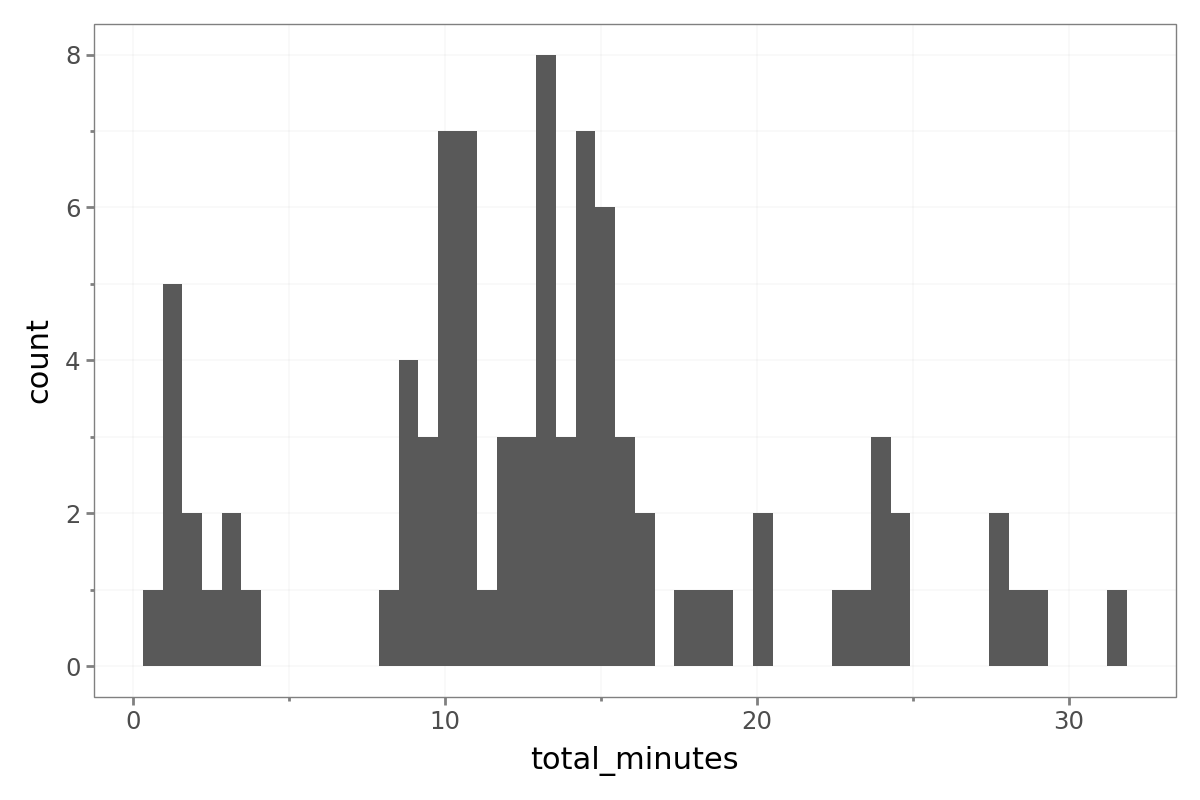

In [63]:
(
    pn.ggplot(
        data=(trials_df.with_columns(total_minutes=pl.col("time_total_s") / 60)),
        mapping=pn.aes("total_minutes"),
    )
    + pn.geom_histogram(bins=50)
    + theme_academic
)

In [64]:
best_hyperparams_df = (
    pl.read_csv("3_SARIMAX_trials.csv")
    .sort("loss")
    .head(1)
    .select(pl.selectors.contains("config/"))
    .unpivot()
    .with_columns(
        pl.col("variable").str.replace("config/", ""), pl.col("value").cast(pl.Int64)
    )
)

best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)

best_hyperparams

{'p': 7, 'q': 3, 'P': 0, 'Q': 1, 'd': 1, 'D': 1}

In [65]:
model = ARIMA(
    order=(
        best_hyperparams["p"],
        best_hyperparams["d"],
        best_hyperparams["q"],
    ),
    season_length=168,
    seasonal_order=(
        best_hyperparams["P"],
        best_hyperparams["D"],
        best_hyperparams["Q"],
    ),
)

# Fit the model on the full data
model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [66]:
y_pred = validation(
    model=model,
    X_train=X_train_preprocessed,
    X_val=X_val_preprocessed,
    y_train=y_train,
    y_val=y_val,
)

y_preds_val = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_val,
    }
)

Hour 744 of 744


In [67]:
loss = root_mean_squared_error(y_pred=y_preds_val["pred"], y_true=y_preds_val["kWh"])
loss

204647.46767750385

In [68]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [69]:
with open("autoarima_model.pkl", "rb") as f:
    model_summary = pickle.load(f)

In [70]:
best_hyperparams_autoarima = {
    "p": sum(1 for key in model_summary["coef"] if key.startswith("ar")),
    "q": sum(1 for key in model_summary["coef"] if key.startswith("ma")),
    "P": sum(1 for key in model_summary["coef"] if key.startswith("sar")),
    "Q": sum(1 for key in model_summary["coef"] if key.startswith("sma")),
    "d": 1,
    "D": 1,
}

best_hyperparams_autoarima

{'p': 21, 'q': 1, 'P': 0, 'Q': 0, 'd': 1, 'D': 1}

In [71]:
model = ARIMA(
    order=(
        best_hyperparams_autoarima["p"],
        best_hyperparams_autoarima["d"],
        best_hyperparams_autoarima["q"],
    ),
    season_length=168,
    seasonal_order=(
        best_hyperparams_autoarima["P"],
        best_hyperparams_autoarima["D"],
        best_hyperparams_autoarima["Q"],
    ),
)

# Fit the model on the full data
model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [72]:
y_pred = validation(
    model=model,
    X_train=X_train_preprocessed,
    X_val=X_val_preprocessed,
    y_train=y_train,
    y_val=y_val,
)

y_preds_val = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_val,
    }
)

Hour 744 of 744


In [73]:
loss = root_mean_squared_error(y_pred=y_preds_val["pred"], y_true=y_preds_val["kWh"])
loss

222841.0352964637

In [74]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

# Holdout Evaluation without Retraining

- fit the model once on the trainval set
- evaluate over the entire year and store predictions

In [75]:
best_hyperparams_df = (
    pl.read_csv("3_SARIMAX_trials.csv")
    .sort("loss")
    .head(1)
    .select(pl.selectors.contains("config/"))
    .unpivot()
    .with_columns(
        pl.col("variable").str.replace("config/", ""), pl.col("value").cast(pl.Int64)
    )
)

best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)

best_hyperparams

{'p': 7, 'q': 3, 'P': 0, 'Q': 1, 'd': 1, 'D': 1}

Do splits:

In [76]:
df_trainval = df_full["2022-09-01":"2023-08-31"]
df_holdout = df_full["2023-09-01":"2024-08-31"]

Preprocess the data:

In [77]:
X_trainval = df_trainval.drop(columns=["kWh"])
X_holdout = df_holdout.drop(columns=["kWh"])

X_trainval_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_trainval),
    columns=preprocessor.get_feature_names_out(),
)

X_holdout_preprocessed = pd.DataFrame(
    preprocessor.transform(X_holdout),
    columns=preprocessor.get_feature_names_out(),
)

In [78]:
y_trainval = df_trainval["kWh"]
y_holdout = df_holdout["kWh"]

Fit model on the training and validation period:

In [ ]:
# Fit model with best hyperparameters on history
model = ARIMA(
    order=(
        best_hyperparams["p"],
        best_hyperparams["d"],
        best_hyperparams["q"],
    ),
    season_length=168,
    seasonal_order=(
        best_hyperparams["P"],
        best_hyperparams["D"],
        best_hyperparams["Q"],
    ),
)

model = model.fit(
    y=y_trainval.to_numpy(dtype=np.float64),
    X=X_trainval_preprocessed.to_numpy(dtype=np.float64),
)

In [ ]:
y_pred = validation(
    model=model,
    X_train=X_trainval_preprocessed,
    X_val=X_holdout_preprocessed,
    y_train=y_trainval,
    y_val=y_holdout,
    verbose=True,
)

In [ ]:
y_preds_holdout = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_holdout,
    }
)

y_preds_holdout.head()

In [ ]:
pl.DataFrame(data=model.model_["coef"]).to_pandas().to_csv(
    "3_SARIMAX_holdout_model_coefficients.csv", index=False
)

In [ ]:
(
    y_preds_holdout.reset_index().to_csv(
        "3_SARIMAX_holdout_predictions_no_retraining.csv", index=False
    )
)

In [ ]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_holdout.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

# Holdout Evaluation with Retraining

Retrain weekly, then predict the entire following week without retraining.

- Training Size: Can not be much longer than a month, so go with that for now

In [ ]:
# best_hyperparams_df = (
#     pl.read_csv("3_SARIMAX_trials.csv")
#     .sort("loss")
#     .head(1)
#     .select(pl.selectors.contains("config/"))
#     .unpivot()
#     .with_columns(
#         pl.col("variable").str.replace("config/", ""), pl.col("value").cast(pl.Int64)
#     )
# )

# best_hyperparams = dict(
#     zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
# )

# best_hyperparams

In [ ]:
# with open("autoarima_model.pkl", "rb") as f:
#     model_summary = pickle.load(f)

# best_hyperparams_autoarima = {
#     "p": sum(1 for key in model_summary["coef"] if key.startswith("ar")),
#     "q": sum(1 for key in model_summary["coef"] if key.startswith("ma")),
#     "P": sum(1 for key in model_summary["coef"] if key.startswith("sar")),
#     "Q": sum(1 for key in model_summary["coef"] if key.startswith("sma")),
#     "d": 1,
#     "D": 1,
# }

# best_hyperparams_autoarima

In [ ]:
# df_trainval = df_full["2022-09-01":"2023-08-31"]
# df_holdout = df_full["2023-09-01":"2024-08-31"]

In [ ]:
# retraining_freq = 7 * 24
# retraining_indices = np.arange(0, df_holdout.shape[0], retraining_freq).tolist()
# y_preds_list = []
# model_coefs_list = []

# for holdout_index in tqdm(retraining_indices):

#     # Preprocess training history df
#     X_train = pd.concat(
#         [
#             df_trainval.iloc[holdout_index:].drop(columns=["kWh"]),
#             df_holdout.iloc[:holdout_index].drop(columns=["kWh"]),
#         ],
#         axis=0,
#     )
#     X_train_preprocessed = pd.DataFrame(
#         preprocessor.fit_transform(X_train),
#         columns=preprocessor.get_feature_names_out(),
#     )

#     X_holdout = df_holdout.iloc[holdout_index : holdout_index + retraining_freq].drop(
#         columns=["kWh"]
#     )
#     X_holdout_preprocessed = pd.DataFrame(
#         preprocessor.transform(X_holdout),
#         columns=preprocessor.get_feature_names_out(),
#     )

#     y_train = pd.concat(
#         [
#             df_trainval.iloc[holdout_index:]["kWh"],
#             df_holdout.iloc[:holdout_index]["kWh"],
#         ],
#         axis=0,
#     )
#     y_holdout = df_holdout.iloc[holdout_index : holdout_index + retraining_freq]["kWh"]

#     # Fit model with best hyperparameters on history
#     model = ARIMA(
#         order=(
#             best_hyperparams["p"],
#             best_hyperparams["d"],
#             best_hyperparams["q"],
#         ),
#         season_length=168,
#         seasonal_order=(
#             best_hyperparams["P"],
#             best_hyperparams["D"],
#             best_hyperparams["Q"],
#         ),
#     )

#     model = model.fit(
#         y=y_train.to_numpy(dtype=np.float64),
#         X=X_train_preprocessed.to_numpy(dtype=np.float64),
#     )

#     # Save the model coefficients for later visualisation
#     model_coefs_list.append(pl.DataFrame(data=model.model_["coef"]))

#     # Make predictions for that week and store them
#     y_pred = validation(
#         model=model,
#         X_train=X_train_preprocessed,
#         X_val=X_holdout_preprocessed,
#         y_train=y_train,
#         y_val=y_holdout,
#         verbose=False,
#     )

#     y_preds_list.append(
#         pd.DataFrame(
#             {
#                 "pred": y_pred,
#                 "kWh": y_holdout,
#             }
#         )
#     )

#     # Increment holdout index
#     holdout_index += retraining_freq

In [ ]:
# (
#     pd.concat(y_preds_list)
#     .reset_index()
#     .to_csv("3_SARIMAX_holdout_predictions_with_retraining.csv", index=False)
# )

In [ ]:
# loss = root_mean_squared_error(
#     y_pred=pl.read_csv("3_SARIMAX_holdout_predictions_with_retraining.csv")["pred"],
#     y_true=pl.read_csv("3_SARIMAX_holdout_predictions_with_retraining.csv")["kWh"],
# )
# loss

In [ ]:
# pl.concat(model_coefs_list, how="vertical").to_pandas().to_csv(
#     "3_SARIMAX_holdout_model_coefficients.csv"
# )

In [ ]:
# # Create the figure with step lines for both actual and predicted values
# fig = px.line(
#     pd.concat(y_preds_list).reset_index(),
#     x="datetime",
#     y=["kWh", "pred"],
#     labels={
#         "datetime": "Date",
#         "value": "Energy Consumption (kWh)",
#         "variable": "Series",
#     },
#     title="Actual vs Predicted Energy Consumption Over Time",
#     line_shape="hv",  # Set line shape to horizontal-vertical for step chart
# )

# # Customize the layout
# fig.update_layout(
#     template="plotly_white",
#     legend=dict(title=""),
#     xaxis_title="Date",
#     yaxis_title="Energy Consumption (kWh)",
# )

# # Show the figure
# fig.show()